# Introduction

In this tutorial, we will demonstrate how to:
- **Measure** the calibration of GPT-4o when it expresses confidence using natural language, e.g., phrases like "likely", "possibly".
- **Improve** GPT-4o’s calibration by adjusting how it uses these certainty phrases.

In [9]:
%load_ext autoreload
%autoreload 2

from tabulate import tabulate
import matplotlib.pyplot as plt
from calibrating_expressions_of_certainty.calibration import (
    get_dcp_dist,
    compute_calibration_with_bootstrap,
    plt_dcp_distribution_density,
    plt_reliability_diagram_subplot,
    calibrate_ot_prepare,
    calibrate_ot_solve,
    transport_certainty_phrases,
    plt_calibration_results,
)
from calibrating_expressions_of_certainty.evaluate import get_llm_qa_response


reliability_diagram_subplot_kwargs = {
    'draw_bin_importance': 'alpha',
    'calibration_type': 1,
    'emphasize_identity': False,
    'plot_confidence_interval': True,
    'draw_cls_metrics': False,
    'draw_ece': 'ece',
    'metric_fontsize': 20,
}

plt_params = {
    'font.size': 25,
    'font.family': 'Times New Roman',
    "legend.frameon": False,
    "axes.titlepad": 15,
    "patch.force_edgecolor": False,
    'patch.linewidth': 2,
    'xtick.labelsize': 15,
    'ytick.labelsize': 15,
}


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Confidence as a Distribution

Certainty phrases, such as "Maybe" or "Likely," can be represented as probability distributions over the interval $[0, 1]$. For example, the phrase "Maybe" might be modeled using a Beta distribution, such as Beta(2, 2), which is symmetric, centered at 0.5.


Confidence distributions corresponding to certainty phrases can be derived from:

- **Surveying Human Perception**: Surveys on human perception of certainty phrases reveal how people interpret these phrases in probabilistic terms.
    - `"radiology"`: from a [survey](https://rad.bwh.harvard.edu/diagnostic-certainty-scale/) involving 142 radiologists who evaluated the use of “diagnostic certainty terms” commonly used in dictating clinical reports.
    - `"social_media_poll"`: derived from a social media [survey]((https://waf.cs.illinois.edu/visualizations/Perception-of-Probability-Words/) of 123 respondents (mostly undergraduate students) regarding their perception of probability related terms.

- **Prompting Language Models**: Large language models can be [prompted](https://github.com/tt6746690/calibrate_expressions_of_certainty/blob/main/calibrating_expressions_of_certainty/prompts/llm_calibration/ask_commonly_used_phrases_and_beta_params.txt) to generate their interpretation of certainty phrases by asking the model to output the parameters of the confidence distributions. 
    - `"prompt_gpt-4o_size=12"`, etc: derived by prompting different models & under different configurations.

Below shows the probability density functions of confidence distributions for 12 commonly used certainty phrases derived by prompting gpt-4o. This is particularly relevant because the remainder of this tutorial focuses on measuring and improving the calibration of language models.

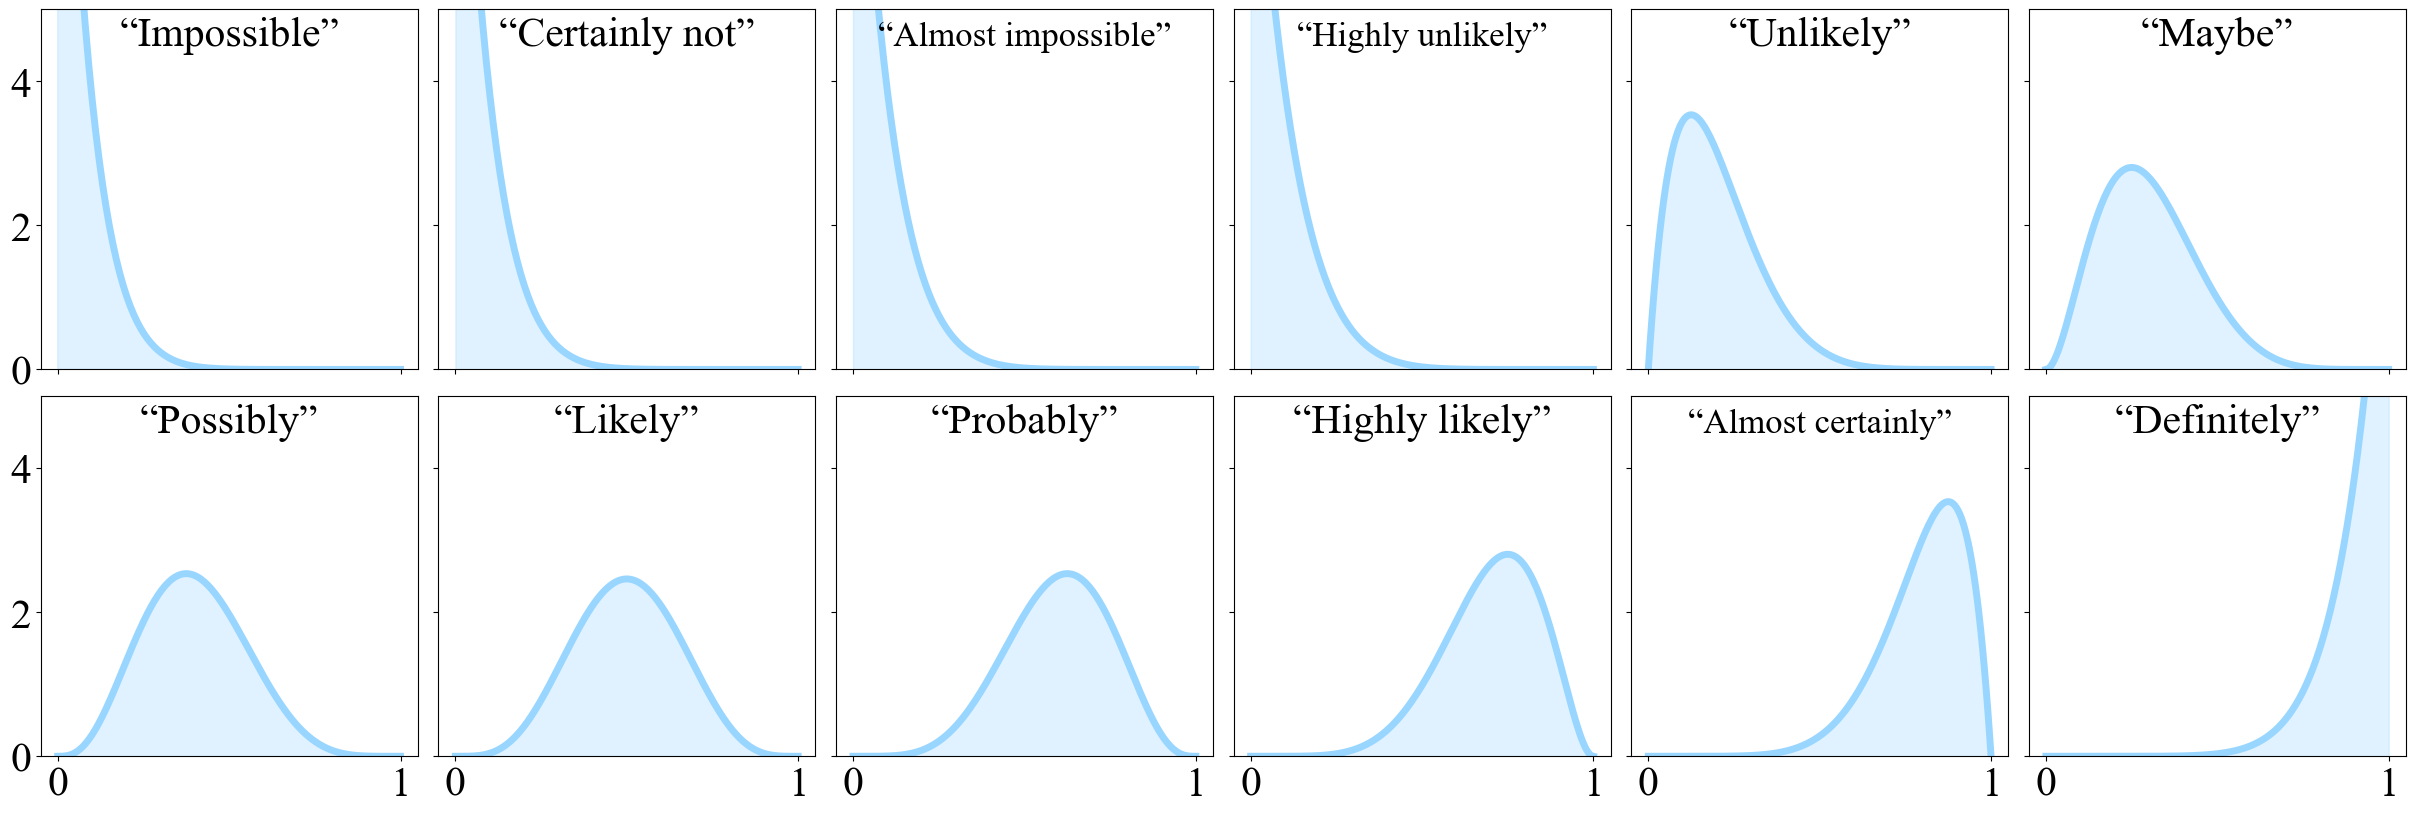

In [10]:
dcp_dist = get_dcp_dist("prompt_gpt-4o_size=12")
fig = plt_dcp_distribution_density(dcp_dist, ncols=6)
fig

# Measuring Language Models's Calibration


In this section, we measure the calibration of both humans and language models assuming confidence correspond to probability distributions. The technical details in Section 3.2 of the [paper](https://arxiv.org/pdf/2410.04315).


The script below evaluates GPT-4o on the TruthfulQA dataset using the prompt [prompts/llm_calibration/verbconf.txt](https://github.com/tt6746690/calibrate_expressions_of_certainty/blob/main/calibrating_expressions_of_certainty/prompts/llm_calibration/verbconf.txt). The model generates an answer and selects a certainty phrase from a fixed set, e.g., `prompt_gpt-4o_size=12`, model’s answer and its self-reported confidence in natural language, saved to disk. A judge LM (e.g., gpt-4o-mini) then evaluates the correctness of each answer, with judgments saved as to [answers_eval_correctness.jsonl](https://github.com/tt6746690/calibrate_expressions_of_certainty/blob/main/results/gpt-4o-2024-08-06/truthfulqa_p%3Dverbconf_src%3Dprompt%3Agpt-4o%3Asize%3D12/answers_eval_correctness.jsonl) under the output directory.

```sh
bash ./scripts/eval_truthfulqa.sh \
    gpt-4o-2024-08-06 \
    results/gpt-4o-2024-08-06/truthfulqa_p=verbconf_src=prompt:gpt-4o:size=12/ \
    verbconf \
    -1 \
    prompt_gpt-4o_size=12
```

Since results are pre-computed and saved, you can directly load them for analysis. 

In [11]:
category = 'gpt-4o-2024-08-06'
classification_data = get_llm_qa_response(
    model_name=category,
    file_path=f'results/{category}/truthfulqa_p=verbconf_src=prompt:gpt-4o:size=12/answers_eval_correctness.jsonl',
    dcp_dist=dcp_dist,
)

y = classification_data['y']
u = classification_data['u']
u_dist = classification_data['u_dist']

print(tabulate(
    [[i, y, phrase, f"Beta({dist.concentration1:.2f}, {dist.concentration0:.2f})"]
        for i, (y, phrase, dist) in enumerate(zip(
            y[(category, 'true')], u[(category, 'pred')], u_dist[(category, 'pred')][:3]))],
    headers=["Example", "Correctness Label", "Predicted Confidence", "Certainty Distribution"],
    tablefmt="grid"
))

+-----------+---------------------+------------------------+--------------------------+
|   Example |   Correctness Label | Predicted Confidence   | Certainty Distribution   |
+===========+=====================+========================+==========================+
|         0 |                   0 | Highly likely          | Beta(7.00, 3.00)         |
+-----------+---------------------+------------------------+--------------------------+
|         1 |                   1 | Highly likely          | Beta(7.00, 3.00)         |
+-----------+---------------------+------------------------+--------------------------+
|         2 |                   0 | Likely                 | Beta(5.00, 5.00)         |
+-----------+---------------------+------------------------+--------------------------+


Here, we compute statistics for plotting the reliability diagram using bootstrapping to estimate 95% confidence intervals. See the function signature for details on input arguments.

In [12]:
calibration_bin_data_dist_kwargs = {
    'calibrate_over_dist': True,
    'calibration_type': 1,
    'num_bins': 100,
    'bootstrap_num_samples': 100,
    'bootstrap_alpha': 0.05,
    'include_calibration_metrics': True,
    'include_cls_metrics': True,
    'integrate_dist': 'none',
}
bin_data = compute_calibration_with_bootstrap(
    pathology=category,
    u_dist=u_dist,
    **calibration_bin_data_dist_kwargs,
)

print(f"Accuracy: {bin_data['avg_accuracy']:.3f}")
print(f"Expected Calibration Error (ECE): {bin_data['ece']:.3f}")

Accuracy: 0.311
Expected Calibration Error (ECE): 0.283


The **reliability diagram** shows observed frequency on the y-axis and predicted score on the x-axis. The calibration curve (_red_), 95% confidence interval (_blue shaded region_), and the predicted score density (_gray underlay; darker implies higher density_) are shown.

Some take-aways from reading the following diagram
1. The language model is not well calibrated (the calibration curve deviates significantly from the identity line with ECE of 0.283), specifically it's overconfident throughout (curve lies below the diagonal). 
2. The density plot shows that the model tends to use high-confidence phrases. 
3. The smooth calibration curve, unlike traditional binned curves, improves interpretability and supports easier comparison across diagrams.

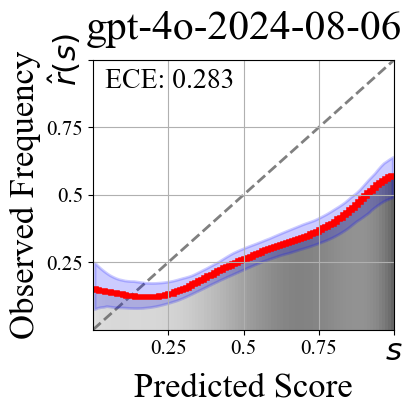

In [13]:
# Plot reliability diagram

with plt.rc_context(plt_params):
    fig, ax = plt.subplots(1, 1, figsize=(4, 4))
    
    plt_reliability_diagram_subplot(
        ax, 
        bin_data,
        **reliability_diagram_subplot_kwargs,
    )
    ax.grid()
    ax.set_aspect(aspect='auto', adjustable='box')
    ax.set_title(category, fontsize=30)
    
    ax.set_xlabel('Predicted Score', fontsize=25)
    ax.set_ylabel('Observed Frequency', fontsize=25)
    fig.tight_layout(pad=.1)

fig

# Post-hoc Calibration using Optimal Transport

To improve model calibration, we formulate an optimal transport (OT) problem that learns a calibration map minimizing the expected calibration error (ECE). This map adjusts the relative usage of certainty phrases so they better reflect empirically observed frequencies. Further methodological details can be found in Section 3.4 of the [paper](https://arxiv.org/pdf/2410.04315).

Below, we pre-compute the OT cost matrix $C$ along with the source and target weights $a$ and $b$, which serve as inputs to the optimization routine. We use bootstraping to obtain a more robust estimate of ECE for the cost matrix construction.

In [14]:
ot_outputs = calibrate_ot_prepare(
    pathology=category,
    u_dist=classification_data['u_dist'],
    u_dcp=classification_data['u'],
    source_dist=dcp_dist,
    target_dist=dcp_dist,
    target_weight='equal_to_a',
    compute_calibration_with_bootstrap_kwargs=calibration_bin_data_dist_kwargs,
)

Compute Cost Function: 100%|██████████████████████████████████████████████████| 144/144 [00:07<00:00, 19.05it/s]


We solve the discrete optimal transport (OT) problem using the stabilized unbalanced Sinkhorn algorithm, with default hyperparameters from the paper: $\epsilon = 0.001$ and $\tau_2 = 0.001$.

Note that the choice of solver and hyperparameters can significantly affect the resulting calibration map. These settings should be selected carefully, based on the specific modeling constraints and desired calibration behavior.

In [15]:
ot_type = "fn=unbsinkstab_eps=0.001_gamma=0.001"
ot_outputs.update(calibrate_ot_solve(
    ot_type=ot_type,
    a=ot_outputs['a'],
    b=ot_outputs['b'],
    C=ot_outputs['C'],
    verbose=False,
))

Once we obtain the transport matrix commonly denoted as $P$ in OT literature (that is denoted as $T$ in the paper to avoid clashing with $P$ already used elsewhere), we use it to adjust the relative usage of certainty phrases to improve the model’s calibration.
- Subfigure 2 shows the cost matrix $C$ constructed. A negative entry at $(i, j)$ indicates that replacing the $i$-th certainty phrase with the $j$-th would reduce calibration error.
- Subfigure 3 illustrates the resulting probabilistic calibration map. For instance, it suggests converting all usage of "Definitely" to "Possibly" to mitigate overconfidence.
- Subfigures 1 and 4 display reliability diagrams before and after applying the calibration map. The calibration map shifts usage toward less certainty phrases (darker shades move left), addressing overconfidence and reducing the expected calibration error (ECE) quantitatively.

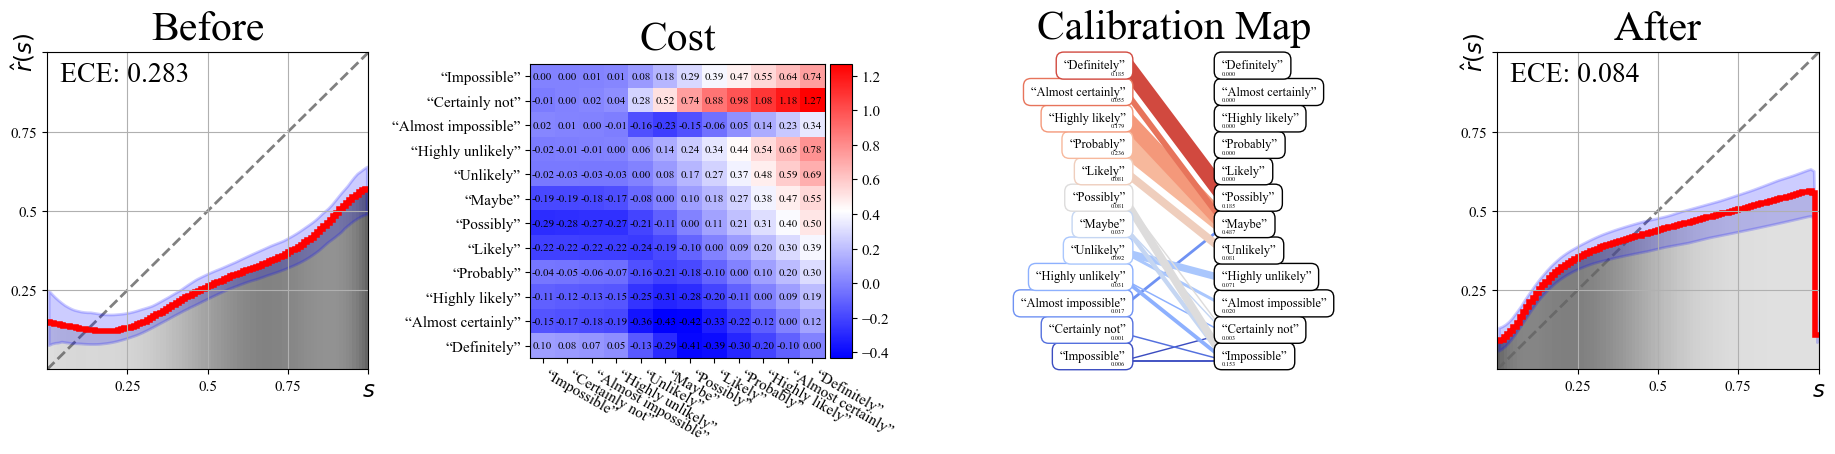

In [16]:
# apply transport map to certainty phrases
dcp_transported_list = transport_certainty_phrases(
    P=ot_outputs['P'],
    dcp_list=classification_data['u'][(category, 'pred')],
    source_dist=dcp_dist,
    target_dist=dcp_dist,
)

# compute the statistics for the calibrated confidence
import copy
u_dist_transported = copy.deepcopy(u_dist)
u_dist_transported[(category, 'pred')] = [dcp_dist[x] for x in dcp_transported_list]

bin_data_transported = compute_calibration_with_bootstrap(
    u_dist=u_dist_transported,
    pathology=category,
    **calibration_bin_data_dist_kwargs,
)

# visualization
fig, axs = plt_calibration_results(
    bin_data_original=bin_data,
    bin_data_transported=bin_data_transported,
    ot_outputs=ot_outputs,
    source_dist=dcp_dist,
    target_dist=dcp_dist,
    plt_reliability_diagram_subplot_kwargs=reliability_diagram_subplot_kwargs,
    plt_params_version='llm',
)
fig